In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.layers import Dense , Input , Conv2D, Conv2DTranspose , Flatten, Reshape
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar100
from keras import backend as K

Using TensorFlow backend.


# function to convert color images to Gray-scale

In [0]:
def rgb_2_gray(image):
  return np.dot(image[... , :3] , [0.299 , 0.587 , 0.114])

Load CIFAR100 dataset

In [0]:
(x_train , _) , (x_test , _) = cifar100.load_data()

169009152/169001437 [==============================] - 11s 0us/step


In [0]:
rows = x_train.shape[1]
cols = x_train.shape[2]
channels = x_train.shape[3]

Create a directory to save images an results

In [0]:
img_dir = 'saved_results'
save_dir = os.path.join(os.getcwd(), img_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

Lets take a look at the colour images of the dataset

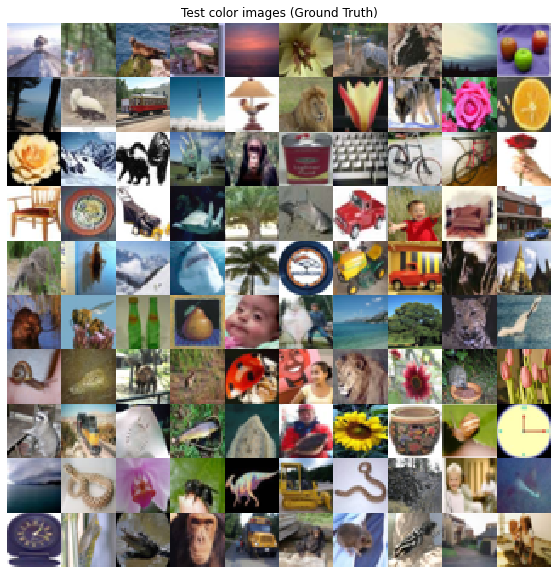

In [0]:
img = x_test[:100]
img = img.reshape((10, 10, rows, cols, channels))
img = np.vstack([np.hstack(i) for i in img])

plt.figure(figsize = (10,10))
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(img, interpolation='none')
plt.savefig('%s/test_color.png' % img_dir)
plt.show()

Corresponding images in gray-scale

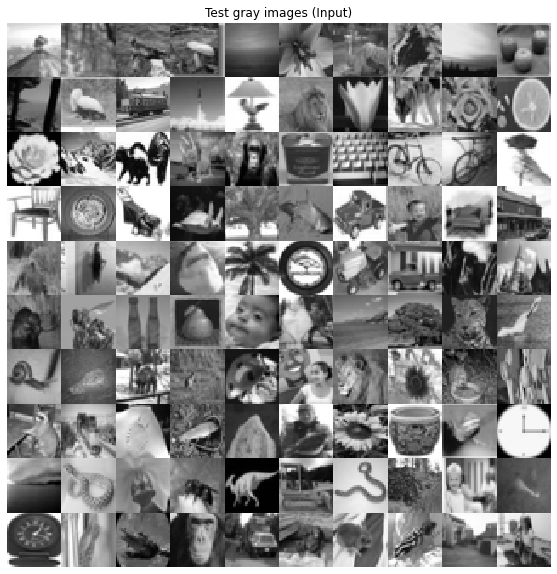

In [0]:
# convert color train and test images to gray
x_train_gray = rgb_2_gray(x_train)
x_test_gray = rgb_2_gray(x_test)

# display grayscale version of test images
img = x_test_gray[:100]
img = img.reshape((10, 10, rows, cols))
img = np.vstack([np.hstack(i) for i in img])

plt.figure(figsize = (10 , 10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(img, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % img_dir)
plt.show()

Normalize both the colour and grayscale images

In [0]:
#normalize both color and gray scale 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

reshaping

In [0]:
#reshaping
#x_train = x_train.reshape((x_train[0] , rows , cols , channels))
#x_test = x_test.reshape(x_test[0] , rows , cols , channels)

x_train_gray = x_train_gray.reshape(50000 , rows , cols , 1)
x_test_gray = x_test_gray.reshape(10000 , rows , cols , 1)

Defining the hyper-parameters in the network

In [0]:
#hyperparameters
input_shape = (rows, cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

Creating the eencoder part of the Autoencoder with increasing filter 

In [0]:
#build the model

inputs = Input(shape = input_shape)
x = inputs

# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
  x = Conv2D(filters=filters,
           kernel_size=kernel_size,
           strides=2,
           activation='relu',
           padding='same')(x)

Getting the latent vector

In [0]:

shape = K.int_shape(x)
# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [0]:
shape

(None, 4, 4, 256)

In [0]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

We buid the Decoder model, whose Input is the latent vector, folowed by a Dense layer and Conv2DTranspose of decreaing filter numbers

In [0]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-
# Conv2DTranspose(64)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      activation='relu',
                      padding='same')(x)

Defining the output of the Decoder, we use filter = channel = 3, because during backpropagation,we a going to compare the images with the ground truth which are colour images.

In [0]:
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

In [0]:

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

In [0]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

Based on the performance, we would like to reduce the Learning Rate

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

[Optional] We can save the best model, in the mentioned directory, time to time based on the validation loss

In [0]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

Compiling the Model, with loss = Mean Squared Error and Optimizer = Adam

In [0]:
autoencoder.compile(loss='mse', optimizer='adam')

In [0]:
callbacks = [lr_reducer, checkpoint]

In [0]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)




Train on 50000 samples, validate on 10000 samples
Epoch 1/30





50000/50000 [==============================] - 57s 1ms/step - loss: 0.0189 - val_loss: 0.0144

Epoch 00001: val_loss improved from inf to 0.01443, saving model to /content/saved_models/colorized_ae_model.001.h5
Epoch 2/30
50000/50000 [==============================] - 44s 885us/step - loss: 0.0135 - val_loss: 0.0135

Epoch 00002: val_loss improved from 0.01443 to 0.01350, saving model to /content/saved_models/colorized_ae_model.002.h5
Epoch 3/30
50000/50000 [==============================] - 44s 887us/step - loss: 0.0125 - val_loss: 0.0127

Epoch 00003: val_loss improved from 0.01350 to 0.01267, saving model to /content/saved_models/colorized_ae_model.003.h5
Epoch 4/30
50000/50000 [==============================] - 44s 883us/step - loss: 0.0118 - val_loss: 0.0117

Epoch 00004: val_loss improved from 0.01267 to 0.01171, saving model to /content/saved_models/colorized_ae_model.004.h5
Epoch 5/30
50000/50000 [============

In [0]:
x_decoded = autoencoder.predict(x_test_gray)

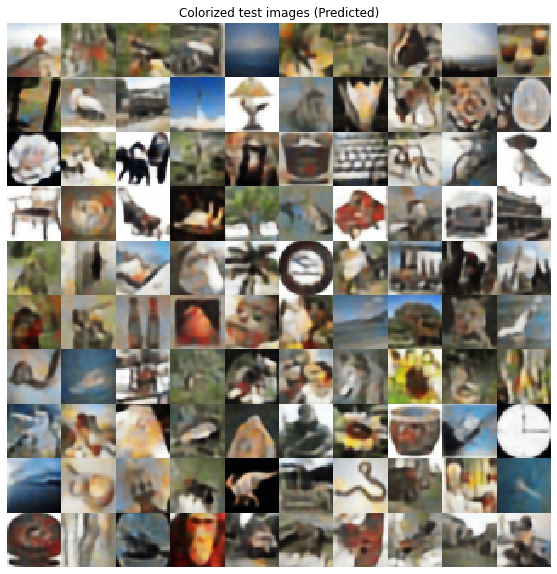

In [0]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, rows, cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize = (10 ,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % img_dir)
plt.show()